In [1]:
import librosa
import librosa.display
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

from vocoder import Channel_Vocoder
from carriers import sawtooth_osc, square_osc

In [2]:
# Basic params
sr = 44100
hop_length = 512
n_fft = 2048

In [3]:
# Utils
def compare_stft(source, output):
    fig, axes = plt.subplots(1,2, figsize=(22,8))
    
    stft_source = librosa.stft(source, window='hann', n_fft=n_fft, hop_length=hop_length)
    img = librosa.display.specshow(librosa.power_to_db(stft_source, ref=np.max), x_axis="time", y_axis="linear", sr=sr, ax=axes[0])
    axes[0].set_title("Source")
    plt.colorbar(img, ax=axes[0], format="%+2.f dB")

    stft_output = librosa.stft(output, window='hann', n_fft=n_fft, hop_length=hop_length)
    img = librosa.display.specshow(librosa.power_to_db(stft_output, ref=np.max), x_axis="time", y_axis="linear", sr=sr, ax=axes[1])
    axes[1].set_title("Output")
    plt.colorbar(img, ax=axes[1], format="%+2.f dB")

In [4]:
# Audio Selection
import ipywidgets as widgets

w = widgets.Dropdown(
    options=[('dog_sound', 'dog_sound'), 
             ('suzanne', 'suzanne')],
    value='dog_sound',
    description='Select audio:',
)
ipd.display(w)

Dropdown(description='Select audio:', options=(('dog_sound', 'dog_sound'), ('suzanne', 'suzanne')), value='dog…

In [5]:
# Load Audio
modulator_x, _ = librosa.load("./audio/{}.wav".format(w.value), sr=sr) 
print(modulator_x.shape)
ipd.Audio(modulator_x, rate=sr)

(218170,)


## 바보짓 고치기

### 1. 전체에 stft 한 뒤 hadarmard 곱

In [6]:
class Channel_Vocoder():
    def __init__(self, n_channel, sr, hop_length=256, n_fft=1024):
        self.n_channel = n_channel
        self.sr = sr
        self.hop_length = hop_length
        self.n_fft = n_fft
        
    def __call__(self, modulator_x, carrier_type='sawtooth', carrier_f0=440):
        # Set carrier signal
        dur = modulator_x.shape[0]
        if carrier_type == 'sawtooth':
            carrier_x = sawtooth_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        elif carrier_type == 'square':
            carrier_x = square_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        else:
            # TODO: 여기 종류 더 많아지면 개선 필요
            print("Carrier Type Error")
            
        # STFT
        modulator_x = librosa.stft(modulator_x, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
        carrier_x = librosa.stft(carrier_x, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
        
        # Muliply freq components
        y = np.multiply(modulator_x, carrier_x) # 여기서 freq를 좀 바꿔가면서 실험 -> shift 정도를 랜덤으로
        return librosa.istft(y)
        

### - carrier f0 = 440

In [7]:
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440)
ipd.Audio(output, rate=sr)

/home/jnwn/anaconda3/envs/gct535/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


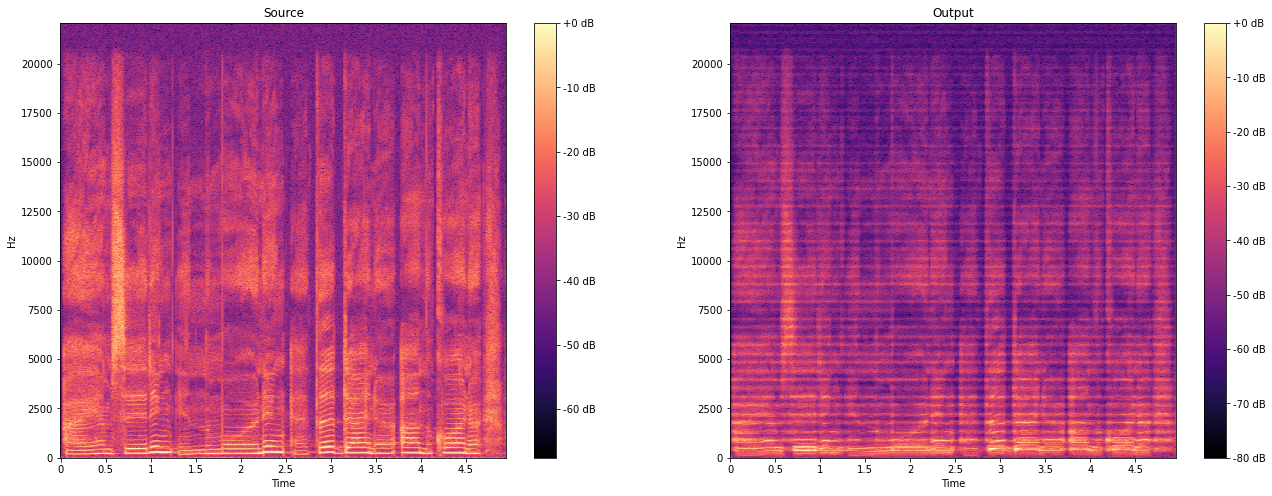

In [8]:
compare_stft(modulator_x, output)

### - carrier f0 = 880

In [9]:
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=880)
ipd.Audio(output, rate=sr)

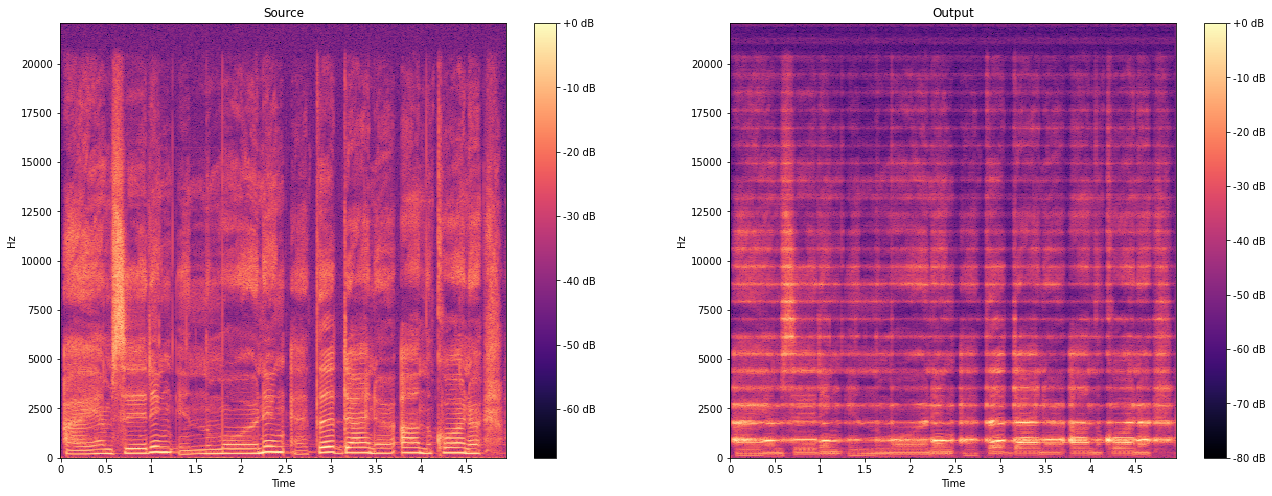

In [10]:
compare_stft(modulator_x, output)

### 2. 밴드패싱한 block 별로 stft 

In [11]:
class Channel_Vocoder():
    def __init__(self, n_channel, sr, hop_length=256, n_fft=1024, freq_scale='linear', filter_type='butter'):
        self.n_channel = n_channel
        self.sr = sr
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.freq_scale = freq_scale
        self.filter_type = filter_type
        
        # Set band-pass filters
        nyq = sr * 0.5
        if self.freq_scale == 'linear':
            bp_range = nyq // self.n_channel
            self.bp_filters = [Bandpass_Filter(i*bp_range, (i+1)*bp_range, nyq, filter_type=self.filter_type) for i in range(self.n_channel)]
        elif self.freq_scale == 'mel':
            mel_freqs = librosa.mel_frequencies(n_mels=self.n_channel+1, fmin=0.0, fmax=nyq-1).tolist()
            self.bp_filters = [Bandpass_Filter(f0, f1, nyq, filter_type=self.filter_type) for f0, f1 in zip(mel_freqs[:-1], mel_freqs[1:])]
        
    def __call__(self, modulator_x, carrier_type='sawtooth', carrier_f0=440, high_noise=False, noise_amp=1, noise_Q=1):
        # Set carrier signal
        dur = modulator_x.shape[0]
        if carrier_type == 'sawtooth':
            carrier_x = sawtooth_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        elif carrier_type == 'square':
            carrier_x = square_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        else:
            # TODO: 여기 종류 더 많아지면 개선 필요
            print("Carrier Type Error")
        
        ############# add high-freq noise ############# 
        if not (noise_amp > 0 and noise_amp <= 1):
            raise ValueError('noise_amp should be in range (0,1)')
        
        if high_noise:
            rand_noise = (np.random.rand(dur)-0.5)*2*noise_amp
            # bi-quad highpass filter
            cut_off_freq = (8e3 + 16e3)//2
            Q = noise_Q

            theta = 2*np.pi*cut_off_freq/sr
            alpha = np.sin(theta)/2/Q
            b = [(1+np.cos(theta)), -2*(1+np.cos(theta)), (1+np.cos(theta))]
            a = [(1+alpha), -2*np.cos(theta), (1-alpha)]
            rand_noise = signal.lfilter(b,a,rand_noise)
            
            carrier_x = carrier_x + rand_noise
            # clipping
            if any(carrier_x > 1):
                carrier_x[carrier_x>1] = 1
            if any(carrier_x < -1):
                carrier_x[carrier_x<-1] = -1
        ###############################################
        
        y = np.zeros((self.n_fft//2 + 1, modulator_x.shape[0]//self.hop_length + 1))
        for channel_idx in range(self.n_channel):
            # Band-pass
            bp_filter = self.bp_filters[channel_idx]
            modulator_block = bp_filter(modulator_x)
            carrier_block = bp_filter(carrier_x)
            
            # STFT
            modulator_block = librosa.stft(modulator_block, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
            carrier_block = librosa.stft(carrier_block, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
            
            # Multipy and stack it
            y = np.add(y, np.multiply(modulator_block, carrier_block), casting='unsafe')
            
        return librosa.istft(y)

    
class Bandpass_Filter():
    def __init__(self, low, high, nyq, filter_type='butter', order=10):
        self.low = int(1 if low == 0 else low)
        self.high = int(nyq-1 if high == nyq else high)
        filter_types = ['butter', 'cheby1', 'bessel', 'biquad']
        if filter_type not in filter_types:
            raise ValueError(f'filter_type should be one of {filter_types}.')
        
        if filter_type == 'butter':
            self.sos = signal.butter(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'cheby1':
            self.sos = signal.cheby1(order, rp=0.1, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'bessel':
            self.sos = signal.bessel(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos', norm='phase')
        elif filter_type == 'biquad':
            cutoff_freq = (self.low + self.high) / 2
            Q = order
            sr = 2*nyq
            # bi-quad lowpass filter -> bandpass로 바꾸기..?
            theta = 2*np.pi*cutoff_freq/sr
            alpha = np.sin(theta)/2/Q
            b = [(1-np.cos(theta)), 2*(1-np.cos(theta)), (1-np.cos(theta))]
            a = [(1+alpha), -2*np.cos(theta), (1-alpha)]
            self.sos = signal.tf2sos(b, a)
        
    def __call__(self, x):
        return signal.sosfilt(self.sos, x)
        

In [12]:
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440, high_noise=True, noise_amp=1, noise_Q=5)
ipd.Audio(output, rate=sr)

In [13]:
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440, high_noise=True, noise_amp=0.5, noise_Q=5)
ipd.Audio(output, rate=sr)

In [14]:
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440, high_noise=True, noise_amp=0.5, noise_Q=1)
ipd.Audio(output, rate=sr)

In [15]:
channel_vocoder = Channel_Vocoder(n_channel=20, sr=sr)
output = channel_vocoder(modulator_x, carrier_type='sawtooth', carrier_f0=440, high_noise=True, noise_amp=0.5, noise_Q=10)
ipd.Audio(output, rate=sr)

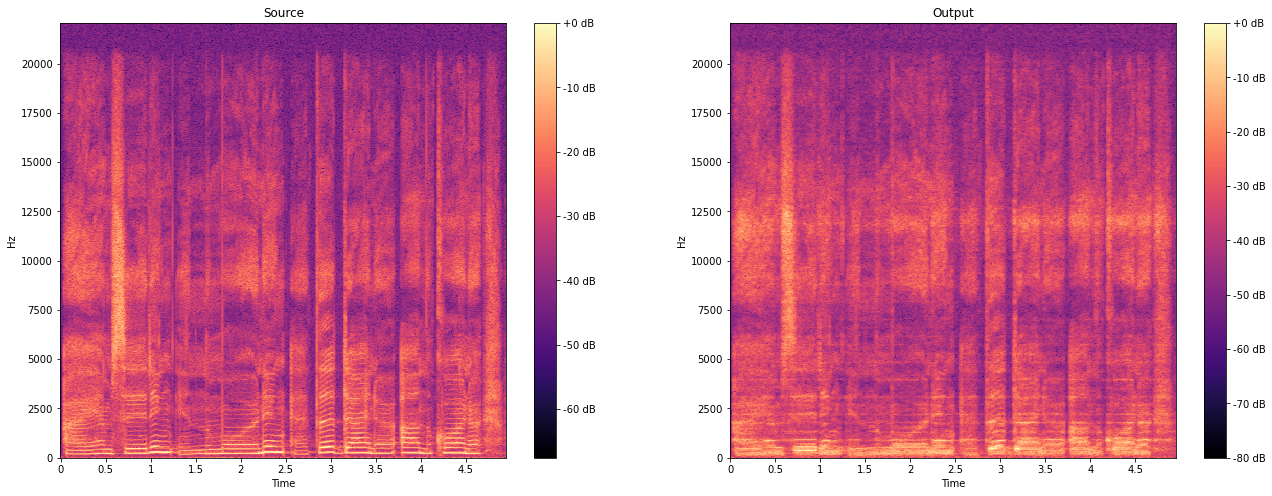

In [16]:
compare_stft(modulator_x, output)

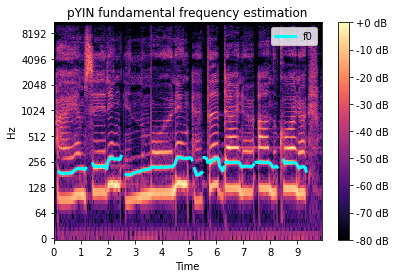

In [32]:
# y, sr = librosa.load(librosa.ex('trumpet'))
f0, voiced_flag, voiced_probs = librosa.pyin(modulator_x,
                                             fmin=librosa.note_to_hz('C2'), # 1, 
                                             fmax=librosa.note_to_hz('C7'), # sr * 0.5,
                                             sr=sr,
                                             frame_length=n_fft,
                                             #win_length=n_fft-1,
                                             hop_length=hop_length)
times = librosa.times_like(f0)

D = librosa.amplitude_to_db(np.abs(librosa.stft(modulator_x,window='hann', n_fft=n_fft, hop_length=hop_length)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

In [29]:
f0.shape

(427,)

In [30]:
D.shape

(1025, 427)

In [19]:
f0

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,  96.8732461 ,
        96.8732461 ,  95.20902171,  94.11545283,  93.03444465,
        93.03444465,  91.96585291,  91.96585291,  91.96585291,
        91.96585291,  93.03444465,  93.03444465,  93.03444465,
        93.5733877 ,  93.5733877 ,  93.03444465,  93.03444465,
        92.49860568,  94.11545283,  94.11545283,  94.6606581 ,
        94.6606581 ,  95.76056196,  95.76056196,  99.13755089,
        99.71184888, 101.45478129, 102.04250286, 103.82617439,
       104.4276333 , 105.64102396, 106.25299618, 106.86851353,
       106.86851353, 106.25299618, 106.25299618, 106.25299618,
       106.25299618, 106.25299618, 105.64102396, 105.64102396,
       105.03257643, 103.22817963, 103.22817963, 106.86851353,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, 120.65074777, 114.53

In [38]:
np.round(f0/(sr//2+1)*(n_fft//2 + 1))

array([nan, nan, nan, nan, nan, nan, nan, nan,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 11., 11., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 11., 12., 12., 13., 13., 13.,
       13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 13.,
       12., 13., 13., 14., nan, nan, nan, nan, nan, nan, nan,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10

In [ ]:
class Channel_Vocoder():
    def __init__(self, n_channel, sr, hop_length=256, n_fft=1024, freq_scale='linear', filter_type='butter'):
        self.n_channel = n_channel
        self.sr = sr
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.freq_scale = freq_scale
        self.filter_type = filter_type
        
        # Set band-pass filters
        nyq = sr * 0.5
        if self.freq_scale == 'linear':
            bp_range = nyq // self.n_channel
            self.bp_filters = [Bandpass_Filter(i*bp_range, (i+1)*bp_range, nyq, filter_type=self.filter_type) for i in range(self.n_channel)]
        elif self.freq_scale == 'mel':
            mel_freqs = librosa.mel_frequencies(n_mels=self.n_channel+1, fmin=0.0, fmax=nyq-1).tolist()
            self.bp_filters = [Bandpass_Filter(f0, f1, nyq, filter_type=self.filter_type) for f0, f1 in zip(mel_freqs[:-1], mel_freqs[1:])]
        
    def __call__(self, modulator_x, carrier_type='sawtooth', carrier_f0=440, high_noise=False, noise_amp=1, noise_Q=1):
        # Set carrier signal
        dur = modulator_x.shape[0]
        if carrier_type == 'sawtooth':
            carrier_x = sawtooth_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        elif carrier_type == 'square':
            carrier_x = square_osc(f0=carrier_f0, dur=dur, sr=self.sr)
        else:
            # TODO: 여기 종류 더 많아지면 개선 필요
            print("Carrier Type Error")
        
        ############# add high-freq noise ############# 
        if not (noise_amp > 0 and noise_amp <= 1):
            raise ValueError('noise_amp should be in range (0,1)')
        
        if high_noise:
            rand_noise = (np.random.rand(dur)-0.5)*2*noise_amp
            # bi-quad highpass filter
            cut_off_freq = (8e3 + 16e3)//2
            Q = noise_Q

            theta = 2*np.pi*cut_off_freq/sr
            alpha = np.sin(theta)/2/Q
            b = [(1+np.cos(theta)), -2*(1+np.cos(theta)), (1+np.cos(theta))]
            a = [(1+alpha), -2*np.cos(theta), (1-alpha)]
            rand_noise = signal.lfilter(b,a,rand_noise)
            
            carrier_x = carrier_x + rand_noise
            # clipping
            if any(carrier_x > 1):
                carrier_x[carrier_x>1] = 1
            if any(carrier_x < -1):
                carrier_x[carrier_x<-1] = -1
        ###############################################
        
        y = np.zeros((self.n_fft//2 + 1, modulator_x.shape[0]//self.hop_length + 1))
        for channel_idx in range(self.n_channel):
            # Band-pass
            bp_filter = self.bp_filters[channel_idx]
            modulator_block = bp_filter(modulator_x)
            carrier_block = bp_filter(carrier_x)
            
            # STFT
            modulator_block = librosa.stft(modulator_block, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
            ### modulator_block의 f0가 carrier_block의 f0와 일치하도록 조절,,
            carrier_block = librosa.stft(carrier_block, window='hann', n_fft=self.n_fft, hop_length=self.hop_length)
            
            # Multipy and stack it
            y = np.add(y, np.multiply(modulator_block, carrier_block), casting='unsafe')
            
        return librosa.istft(y)

    
class Bandpass_Filter():
    def __init__(self, low, high, nyq, filter_type='butter', order=10):
        self.low = int(1 if low == 0 else low)
        self.high = int(nyq-1 if high == nyq else high)
        filter_types = ['butter', 'cheby1', 'bessel', 'biquad']
        if filter_type not in filter_types:
            raise ValueError(f'filter_type should be one of {filter_types}.')
        
        if filter_type == 'butter':
            self.sos = signal.butter(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'cheby1':
            self.sos = signal.cheby1(order, rp=0.1, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos')
        elif filter_type == 'bessel':
            self.sos = signal.bessel(order, Wn=[self.low/nyq, self.high/nyq], btype='bandpass', output='sos', norm='phase')
        elif filter_type == 'biquad':
            cutoff_freq = (self.low + self.high) / 2
            Q = order
            sr = 2*nyq
            # bi-quad lowpass filter -> bandpass로 바꾸기..?
            theta = 2*np.pi*cutoff_freq/sr
            alpha = np.sin(theta)/2/Q
            b = [(1-np.cos(theta)), 2*(1-np.cos(theta)), (1-np.cos(theta))]
            a = [(1+alpha), -2*np.cos(theta), (1-alpha)]
            self.sos = signal.tf2sos(b, a)
        
    def __call__(self, x):
        return signal.sosfilt(self.sos, x)
        